# Train your model in PyTorch
## Introduction
In past videos, we've discussed and demonstrated:
* Building models with the neural network layers and functions of the torch.nn module
* The mechanics of automated gradient computation, which is central to gradient-based model training
* Using TensorBoard to visualize training progress and other activities

In this video, we'll be adding some new tools to your inventory:
* We'll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop
* We'll discuss specific loss functions and when to use them
* We'll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we'll pull all of these together and see a full PyTorch training loop in action.

## Dataset and DataLoader
The `Dataset` and `DataLoader` classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The `Dataset` is responsible for accessing and processing single instances of data.

The `DataLoader` pulls instances of data from the `Dataset` (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The `DataLoader` works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we'll be using the Fashion-MNIST dataset provided by TorchVision. We use `torchvision.transforms.Normalize()` to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms 

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import  datetime

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)


# Class Labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

2024-03-11 00:23:46.916081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 00:23:47.158582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-11 00:23:47.158626: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-11 00:23:48.301236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Training set has 60000 instances
Validation set has 10000 instances


As always, let's visuilize the data as a sanity check:

Coat Bag Coat Trouser


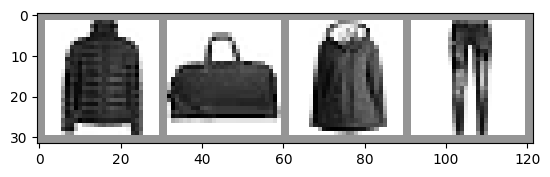

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from image and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))


## The Model

The model we'll use in this example is a variant of LeNet-5 - it should be familiar if you've watched the previous videos in this series.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class GarmetsClassifier(torch.nn.Module):
    def __init__(self):
        super(GarmetsClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = GarmetsClassifier()
